In [1]:
# https://youtu.be/q8SA3rM6ckI?t=3703

# Key Take-Aways:
- Details of Backpropagation

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# character - integer mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build dataset
block_size = 3 # context length for characters

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and create new context
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
# training, dev and test sets
import random
random.seed(42)
random.shuffle(words)
# break points for a 80, 10, 10 split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# comparison function for calculated gradient and pytorch gradient
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters (b1 and b2) n non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
#2
logit_maxes = logits.max(1, keepdim=True).values

norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None

    for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
        norm_logits, logit_maxes, logits, h, hpreact, bnraw,
        bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
        embcat, emb]:
        t.retain_grad()

loss.backward()
loss

tensor(3.3488, grad_fn=<NegBackward0>)

## Derivations of the backpropagation values

In [11]:
# differentiation of the log probabilities for the 27 values produced by the network

dlogprobs = torch.zeros_like(logprobs)  # 0s in the shape of logprobs
dlogprobs[range(n), Yb] = -1.0/n # setting the correct indices of the logprobs to -1/n
cmp('logprobs', dlogprobs, logprobs) # compares the dlogprobs values to those calculated by pytorch

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [12]:
# derivative of the log function * derivative of the differentiated log probs 
# chain rule
dprobs = (1.0/probs) * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [13]:
# differentiate into counts (32, 27) and counts_sum_inv (32, 1)
# implied operation of duplicating counts_sum_inv to perform elementwise multiplication 

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # the columns of counts each have the counts_sum_inv
# value, in differentiation the values are added as per the chain rule
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [14]:
# 1
# differentiate for counts (other factor of probs)

dcounts = counts_sum_inv * dprobs # chain rule at probs (30)

In [15]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
# to differentiate the counts 2 branches must be accounted for: prior (#1) and after counts_sum
# print(counts.shape)
# print(counts_sum.shape)
dcounts  += torch.ones_like(counts) * dcounts_sum  # broadcast the counts values into counts_sum

In [17]:
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
# derivative of norm logits; since the value is .exp the same value (counts) is used

dnorm_logits = counts * dcounts

In [19]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
# again logits is the second value in the network flow

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

In [21]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
# logit_maxes are small values --> near no impact on the change of the final loss
# dlogit_maxes

In [23]:
# 2; second branch of logits
# print(logits.max(1, keepdim=True)) # max value per row plus the indices of the value

# unpack the indices values across sized matrix; 1 in proper index, 0 otherwise; broadcast the 
# dlogit_maxes into this larger matrix shape
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes 

# plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [24]:
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
# linear of the logits; logits = h @ W2 + b2 # output layer

# study the shapes of the values involved
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0) # the dimension that you want to remove... 

In [26]:
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [27]:
# backpropagation of the nonlinear layer tanh

dhpreact = (1.0 - h**2) * dh

In [28]:
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [29]:
# backpropagate for the hpreact value
print(hpreact.shape)
print(bngain.shape)
print(bnraw.shape)
print(bnbias.shape)

torch.Size([32, 64])
torch.Size([1, 64])
torch.Size([32, 64])
torch.Size([1, 64])


In [30]:
# pay attention to the shapes
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

In [31]:
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

bngain          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
bnraw           | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [32]:
# bnraw = bndiff * bnvar_inv

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

In [33]:
cmp('bndiff', dbndiff, bndiff)  # there is another branch that influences the gradient
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bndiff          | exact: False | approximate: False | maxdiff: 0.0012168525718152523
bnvar_inv       | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [34]:
# bnvar_inv = (bnvar + 1e-5)**-0.5

dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv

In [35]:
cmp('dbnvar', dbnvar, bnvar)

dbnvar          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [36]:
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)

dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar

In [37]:
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-11


In [38]:
# bndiff2 = bndiff**2

dbndiff += (2 * bndiff) * dbndiff2  # the second branch is summed in for the gradient

In [39]:
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [40]:
# bndiff = hprebn - bnmeani
print(bndiff.shape, hprebn.shape, bnmeani.shape) # broadcasting in the forward pass --> sum in backward pass

torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])


In [41]:
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)

In [42]:
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)   # first branch = incorrect

bnmeani         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
hprebn          | exact: False | approximate: False | maxdiff: 0.0011490816250443459


In [43]:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True) --> sum forward, broadcast backwards

# torch.ones_like(x) * y has the effect of broadcasting the y value into the correct shape
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

In [44]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [45]:
# hprebn = embcat @ W1 + b1 # hidden layer pre-activation
print(hprebn.shape, embcat.shape, W1.shape, b1.shape)

torch.Size([32, 64]) torch.Size([32, 30]) torch.Size([30, 64]) torch.Size([64])


In [46]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)  # specify the dimension to eliminate --> 64 column

In [47]:
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

embcat          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
W1              | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
b1              | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


In [48]:
# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
print(embcat.shape, emb.shape)  # backwards --> unconcatenate

torch.Size([32, 30]) torch.Size([32, 3, 10])


In [49]:
demb = dembcat.view(emb.shape)

In [50]:
cmp('emp', demb, emb)

emp             | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


In [51]:
# emb = C[Xb] # embed the characters into vectors
print(emb.shape, C.shape, Xb.shape)

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])


In [52]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

In [53]:
cmp('C', dC, C)

C               | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


## Ex 2

In [54]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.3487818241119385 diff:  4.76837158203125e-07


In [55]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

In [56]:
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


In [57]:
# logits represent the predicted probabilities of the values; correct Yb

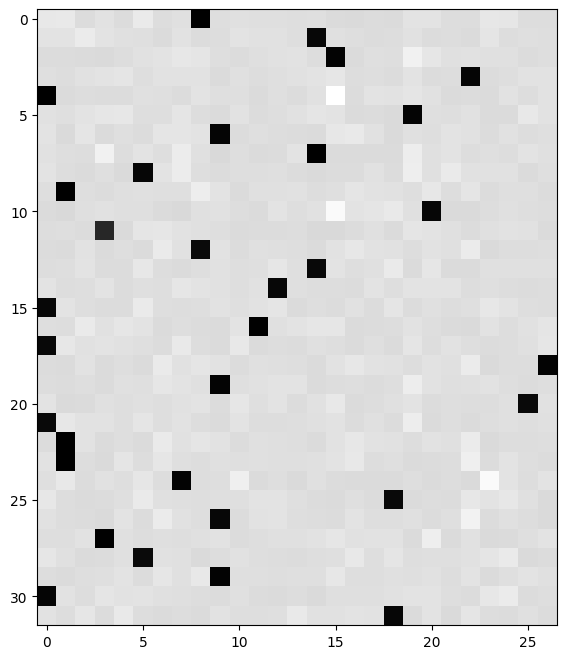

In [58]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [62]:
# forces of push and pull; correct value pulled up, incorrect pushed down
# the amount incorrect dictates how much push and pull

In [60]:
F.softmax(logits, 1)[0]

tensor([0.0761, 0.0783, 0.0179, 0.0489, 0.0203, 0.0854, 0.0221, 0.0374, 0.0182,
        0.0308, 0.0374, 0.0345, 0.0352, 0.0269, 0.0337, 0.0136, 0.0090, 0.0203,
        0.0163, 0.0568, 0.0529, 0.0237, 0.0242, 0.0681, 0.0634, 0.0262, 0.0224],
       grad_fn=<SelectBackward0>)

In [61]:
dlogits[0] * n  # negative value is the correct Yb value; -1 in cell 55

tensor([ 0.0761,  0.0783,  0.0179,  0.0489,  0.0203,  0.0854,  0.0221,  0.0374,
        -0.9818,  0.0308,  0.0374,  0.0345,  0.0352,  0.0269,  0.0337,  0.0136,
         0.0090,  0.0203,  0.0163,  0.0568,  0.0529,  0.0237,  0.0242,  0.0681,
         0.0634,  0.0262,  0.0224], grad_fn=<MulBackward0>)

In [64]:
# simplified preactivations
dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))

In [65]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## Simplified cross-entropy loss, batch normalization backward pass

In [67]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.8092
  10000/ 200000: 2.1960
  20000/ 200000: 2.3482
  30000/ 200000: 2.4631
  40000/ 200000: 2.0220
  50000/ 200000: 2.4464
  60000/ 200000: 2.3707
  70000/ 200000: 2.0109
  80000/ 200000: 2.4195
  90000/ 200000: 2.1261
 100000/ 200000: 1.9169
 110000/ 200000: 2.3858
 120000/ 200000: 1.9955
 130000/ 200000: 2.5099
 140000/ 200000: 2.3304
 150000/ 200000: 2.1921
 160000/ 200000: 1.9306
 170000/ 200000: 1.7813
 180000/ 200000: 2.0780
 190000/ 200000: 1.8459


In [69]:
# # useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [70]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [71]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0719268321990967
val 2.110588550567627


In [79]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        
        # here are the trained values: bngain, bnmean, bnvar, bnbias
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias  # comment and observe...
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mri.
reity.
skanden.
jazonte.
delynn.
jareei.
nellara.
chaiivon.
leigh.
ham.
joce.
quinn.
shoine.
livani.
watell.
dearysi.
jace.
